### Introduction

Acme’s group chats suffer from information overload, key updates get buried, catch-up takes 5–10 minutes, so this project builds a proof-of-concept summarizer that turns long, messenger-style threads into clear, concise recaps. Using the SAMSum dataset (~16k chat–summary pairs), we compare three model families end-to-end: BART (pretrained seq2seq baseline), BERT2BERT (encoder–decoder constructed from BERT), and T5. The pipeline covers data preparation, fine-tuning, evaluation (ROUGE + light human review), and inference, with the aim of delivering summaries that meet ROUGE-1/ROUGE-L ≈ 0.4–0.5 and feel instant with sub-second latency.

### BLUF

Acme’s group chats show classic information overload: important updates get buried in long threads, catch-up takes 5–10 minutes, and users feel overwhelmed. This project introduces an AI summarization prototype trained on the SAMSum dataset (~16k chats) to produce concise, messenger-style recaps that help users grasp the essentials quickly.

We evaluate three models: BART (pretrained seq2seq), BERT2BERT (an encoder–decoder built from BERT), and T5 and assess them with ROUGE plus light human review for fluency and faithfulness. Target performance remains: ROUGE-1/ROUGE-L ≈ 0.4–0.5 and sub-second inference, so summaries feel accurate and instant in real use.

### Data Understanding

In [2]:
!pip install --upgrade transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [52]:
# Standard library
import os
import re
import string
import unicodedata
from collections import Counter
# Data science / plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # optional
# NLP utilities
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import bigrams, trigrams
from wordcloud import WordCloud
# Datasets & metrics
from datasets import load_dataset
import evaluate  # use evaluate.load("rouge")
# PyTorch
import torch

In [4]:
!pip install tf-keras

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [54]:
# Transformers
from transformers import (
    # core training
    TrainingArguments,
    Seq2SeqTrainingArguments,
    Trainer,
    Seq2SeqTrainer,
    EarlyStoppingCallback,
    DataCollatorForSeq2Seq,
    GenerationConfig,

    # tokenizers/models (auto)
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoConfig,

    # BART
    BartTokenizer,
    BartForConditionalGeneration,

    # T5
    T5Tokenizer,
    T5ForConditionalGeneration,

    # BERT encoder-decoder
    EncoderDecoderModel,
    BertModel,
    BertConfig,
    BertTokenizer,
)
# Runtime settings
os.environ["USE_TF"] = "0"
os.environ["TORCH_COMPILE_DISABLE"] = "1"
os.environ["PYTORCH_TRITON_ENABLE_WARNINGS"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Download NLTK data as needed
nltk.download("punkt", quiet=True)

True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)
print("CUDA Available:", torch.cuda.is_available())
print("GPU Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
print("PyTorch Version:", torch.__version__)

# Load model onto GPU
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)

Using Device: cuda
CUDA Available: True
GPU Available: True
Device Name: NVIDIA GeForce RTX 4070 Ti SUPER
PyTorch Version: 2.5.1


In [ ]:
dataset = load_dataset("knkarthick/samsum")
df = dataset["train"].to_pandas()

### Data Cleaning

In [ ]:
def clean_text(text, keep_linebreaks=True):
    # 1) Normalize type + handle missing
    if pd.isna(text):
        return ""
    text = str(text)

    # 2) Unicode normalize (helps with odd punctuation/spacing)
    text = unicodedata.normalize("NFKC", text)

    # 3) Trim weird control chars but keep newlines if desired
    if keep_linebreaks:
        # collapse spaces/tabs but preserve \n
        text = re.sub(r'[ \t]+', ' ', text)
        # reduce excessive blank lines
        text = re.sub(r'\n{3,}', '\n\n', text)
    else:
        # crush all whitespace (including newlines) into single spaces
        text = re.sub(r'\s+', ' ', text)

    # 4) Remove non-printables but allow newline
    text = ''.join(ch for ch in text if ch.isprintable() or ch == '\n')

    # 5) Final trim
    return text.strip()

def clean_example(example):
    example["dialogue"] = clean_text(example["dialogue"], keep_linebreaks=True)
    example["summary"]  = clean_text(example["summary"],  keep_linebreaks=False)
    return example

def is_valid(example):
    return (len(example["dialogue"]) > 10) and (len(example["summary"]) > 5)

df['dialogue'] = df['dialogue'].apply(clean_text)
df['summary'] = df['summary'].apply(clean_text)

# Apply cleaning directly to dataset and overwrite
dataset = dataset.map(clean_example, num_proc=1)  # use num_proc=1 on Windows
dataset = dataset.filter(is_valid, num_proc=1)

### EDA

In [9]:
# Now print the first 5 rows fully
print(df.head(5))

         id                                           dialogue  \
0  13818513  Amanda: I baked cookies. Do you want some?\nJe...   
1  13728867  Olivia: Who are you voting for in this electio...   
2  13681000  Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...   
3  13730747  Edward: Rachel, I think I'm in ove with Bella....   
4  13728094  Sam: hey overheard rick say something\nSam: i ...   

                                             summary  
0  Amanda baked cookies and will bring Jerry some...  
1  Olivia and Olivier are voting for liberals in ...  
2  Kim may try the pomodoro technique recommended...  
3  Edward thinks he is in love with Bella. Rachel...  
4  Sam is confused, because he overheard Rick com...  


In [10]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14732 entries, 0 to 14731
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14732 non-null  object
 1   dialogue  14732 non-null  object
 2   summary   14732 non-null  object
dtypes: object(3)
memory usage: 345.4+ KB
None
              id                                           dialogue  \
count      14732                                              14732   
unique     14732                                              14251   
top     13729017  Jimmy: Hey, guess what? My car's completely ka...   
freq           1                                                  4   

                               summary  
count                            14732  
unique                           14730  
top     Frank likes Macy's red outfit.  
freq                                 2  


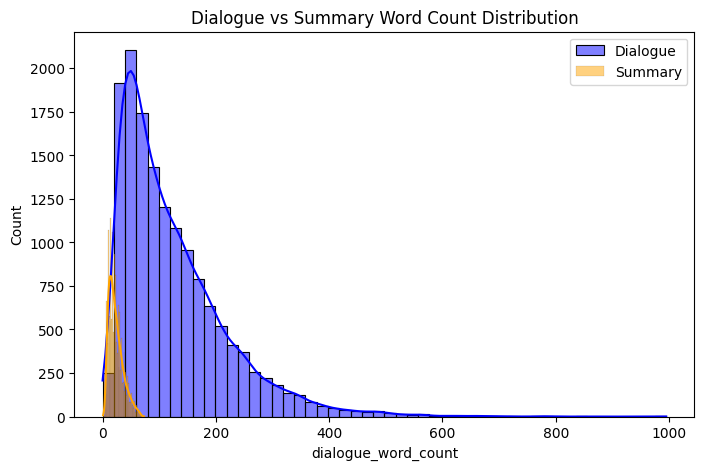

In [ ]:
# Word counts for dialogue and summary
df['dialogue_word_count'] = df['dialogue'].apply(lambda x: len(word_tokenize(x)))
df['summary_word_count'] = df['summary'].apply(lambda x: len(word_tokenize(x)))

plt.figure(figsize=(8,5))
sns.histplot(df['dialogue_word_count'], bins=50, kde=True, label="Dialogue", color='blue')
sns.histplot(df['summary_word_count'], bins=50, kde=True, label="Summary", color='orange')
plt.legend()
plt.title("Dialogue vs Summary Word Count Distribution")
plt.show()

Dialogues are long and heavy-tailed (many >100 words, some extreme outliers), while summaries are short and tightly clustered. This confirms a large compression gap, good for summarization, but watch truncation limits and set shorter max target lengths.

C:\Users\steve\AppData\Local\Temp\ipykernel_18588\3204262956.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Bigram', data=common_bigrams_df, palette="mako")


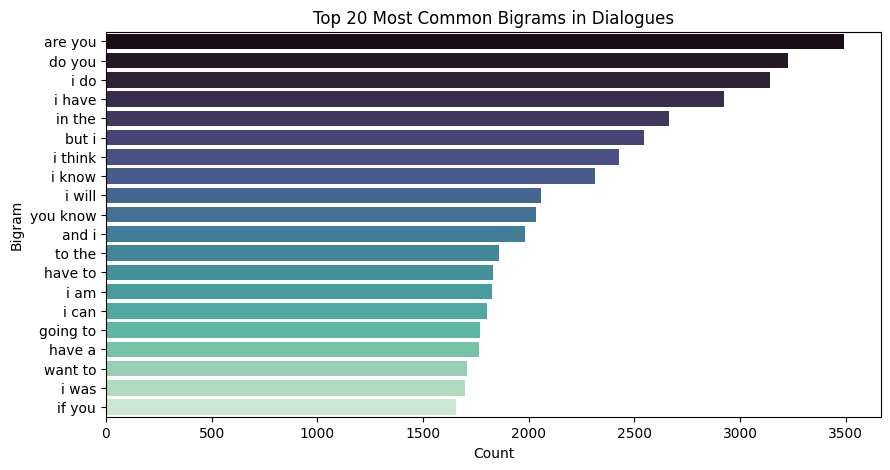

C:\Users\steve\AppData\Local\Temp\ipykernel_18588\3204262956.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Trigram', data=common_trigrams_df, palette="crest")


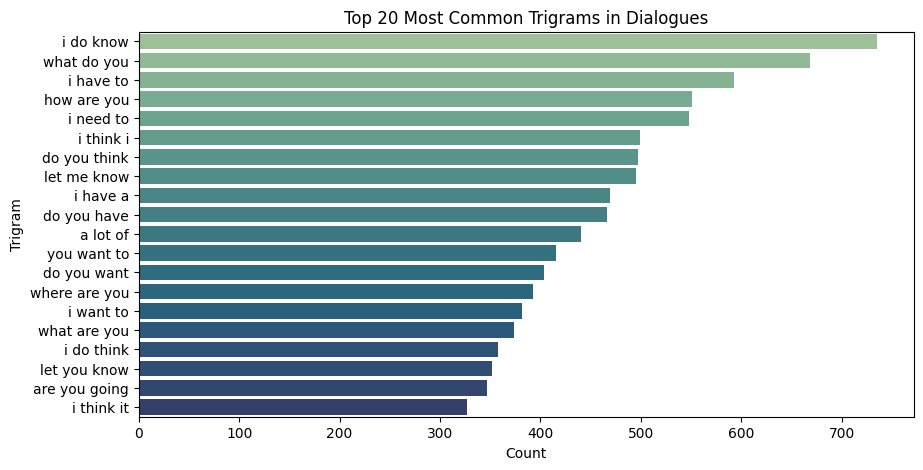

In [ ]:
# Tokenize and keep only alphabetic words
tokenized_dialogues = [
    [word.lower() for word in word_tokenize(text) if word.isalpha()]
    for text in df['dialogue']
]

# --- Most common bigrams ---
all_bigrams = [bg for tokens in tokenized_dialogues for bg in bigrams(tokens)]
bigram_freq = Counter(all_bigrams)
common_bigrams_df = pd.DataFrame(bigram_freq.most_common(20), columns=['Bigram', 'Count'])
common_bigrams_df['Bigram'] = common_bigrams_df['Bigram'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(10,5))
sns.barplot(x='Count', y='Bigram', data=common_bigrams_df, palette="mako")
plt.title("Top 20 Most Common Bigrams in Dialogues")
plt.show()

# --- Most common trigrams ---
all_trigrams = [tg for tokens in tokenized_dialogues for tg in trigrams(tokens)]
trigram_freq = Counter(all_trigrams)
common_trigrams_df = pd.DataFrame(trigram_freq.most_common(20), columns=['Trigram', 'Count'])
common_trigrams_df['Trigram'] = common_trigrams_df['Trigram'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(10,5))
sns.barplot(x='Count', y='Trigram', data=common_trigrams_df, palette="crest")
plt.title("Top 20 Most Common Trigrams in Dialogues")
plt.show()

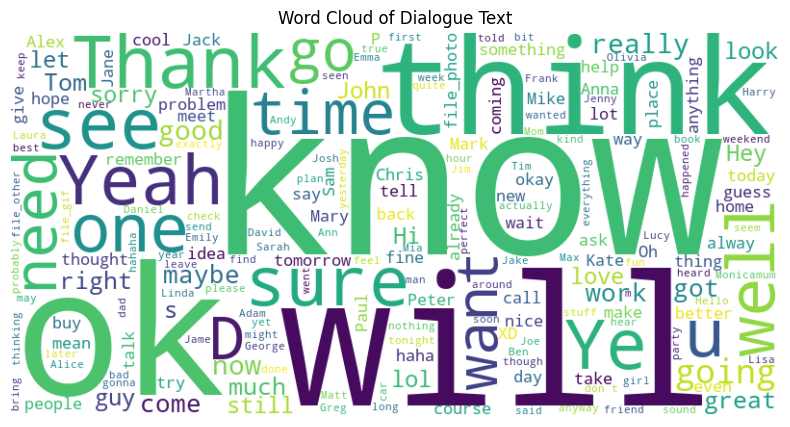

In [ ]:
# Combine all dialogue into one big string
all_words = ' '.join(df['dialogue'].dropna().astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Plot it
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Dialogue Text")
plt.show()

### Modeling: BART

In [ ]:
# Pipeline: filter valid SAMSum rows, tokenize dialogue (encoder) and summary (decoder) for BART, then set PyTorch tensor format.

# ---- 1) Basic filtering ----
# Keep only examples that actually have both fields present.
def is_valid(example):
    return example["dialogue"] is not None and example["summary"] is not None

dataset = dataset.filter(is_valid)

# ---- 2) Load tokenizer for BART ----
# This tokenizer knows how to prepare inputs for the "facebook/bart-base" model.
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

# ---- 3) Tokenization function ----
# - Encodes the dialogue as the source sequence (encoder input)
# - Encodes the summary as the target sequence (decoder labels)
# - Uses max lengths and truncation to keep tensors uniform in size
# - Padding="max_length" ensures fixed-size batches (handy for simple dataloaders)
def tokenize_function(batch):
    # Encoder inputs (source)
    model_inputs = tokenizer(
        batch["dialogue"],
        max_length=512,            # cap long chats; raise if GPU allows
        padding="max_length",
        truncation=True,
    )

    # Decoder labels (targets)
    labels = tokenizer(
        text_target=batch["summary"],  
        max_length=128,                
        padding="max_length",
        truncation=True,
    )

    # Attach labels to the model inputs
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# ---- 4) Apply tokenization to all splits ----
# batched=True -> processes lists for speed; returns dict of tensors/lists
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# ---- 5) Set format for PyTorch ----
tokenized_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)


In [15]:
!pip install --upgrade transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [16]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
# Training + evaluation loop for BART on SAMSum: generate summaries during eval, compute ROUGE, and print scores.

# ---- 1) Model + collator + metric ----
# Load a pretrained BART; move to GPU if available.
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)

# Collator pads batches and converts label pad tokens to -100 (ignored by loss).
collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# ROUGE metric for summarization quality.
rouge = evaluate.load("rouge")

# ---- 2) Custom Trainer that *generates* during evaluation ----
# We override prediction_step so eval uses model.generate(...) instead of raw logits,
# which aligns with how the model will be used in production.
class GenTrainer(Trainer):
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        # Move batch to the correct device
        inputs = self._prepare_inputs(inputs)
        labels = inputs.get("labels", None)

        # Generate summaries (beam search + repetition control)
        with torch.no_grad():
            gen_ids = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs.get("attention_mask"),
                max_length=128,
                num_beams=4,
                no_repeat_ngram_size=3,   # mild anti-repetition
            )

        # Return tensors: (loss, predictions, labels). Loss can be None at eval.
        return (None, gen_ids, labels)

# ---- 3) Metric computation ----
def compute_metrics(eval_pred):
    preds, labels = eval_pred

    # Some HF versions wrap predictions in a tuple
    if isinstance(preds, tuple):
        preds = preds[0]

    # NOTE: preds from generate() normally don't contain -100; replacing is harmless.
    preds  = np.where(preds  == -100, tokenizer.pad_token_id, preds)
    labels = np.where(labels == -100, tokenizer.pad_token_id, labels)

    # Decode token IDs to text
    decoded_preds  = tokenizer.batch_decode(preds,  skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Light normalization for fair ROUGE
    decoded_preds  = [" ".join(p.split()) for p in decoded_preds]
    decoded_labels = [" ".join(l.split()) for l in decoded_labels]

    # Compute ROUGE and report as percentages
    scores = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v * 100, 2) for k, v in scores.items()}

# ---- 4) Training arguments ----
args = TrainingArguments(
    output_dir="./bart-samsum",
    do_train=True,
    do_eval=True,
    max_steps=2000,                 # If set > 0, this overrides num_train_epochs below
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,             # Ignored when max_steps > 0
    weight_decay=0.01,
    logging_steps=200,
    save_total_limit=2,
    torch_compile=False,            # keep off for broader compatibility
    report_to="none",               # silence wandb/tensorboard unless you want them
)

# ---- 5) Trainer, train, evaluate ----
trainer = GenTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
metrics = trainer.evaluate()

# ---- 6) Print ROUGE nicely ----
print("\n=== ROUGE SCORES ===")
for k in ['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum']:
    print(f"{k.replace('eval_', '').upper():<10} : {metrics[k]:.2f}")


C:\Users\steve\AppData\Local\Temp\ipykernel_18588\3009543372.py:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `GenTrainer.__init__`. Use `processing_class` instead.
  trainer = GenTrainer(
c:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\transformers\data\data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss
200,1.709900
400,0.435500
600,0.407900
800,0.394700
1000,0.394400
1200,0.388400
1400,0.384900
1600,0.372500
1800,0.371700
2000,0.340300


c:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\transformers\modeling_utils.py:3909: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



=== ROUGE SCORES ===
ROUGE1     : 50.34
ROUGE2     : 26.35
ROUGEL     : 42.00
ROUGELSUM  : 42.03


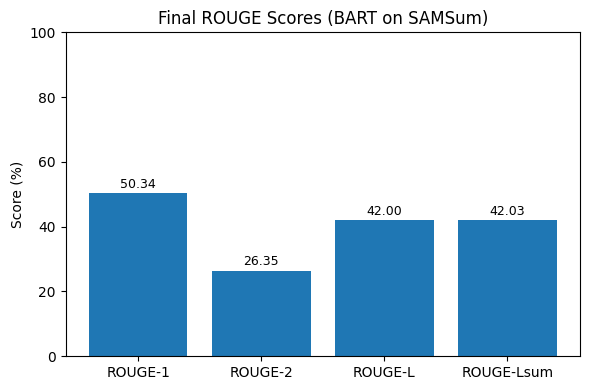

In [ ]:
# Plot helper: bar chart of ROUGE scores (expects % values and eval_* keys from Trainer.evaluate)

def plot_final_rouge(metrics):
    # Keys we expect from HF Trainer.evaluate; adjust if you use plain 'rouge1' etc.
    keys = ["eval_rouge1", "eval_rouge2", "eval_rougeL", "eval_rougeLsum"]
    labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum"]

    # Pull values (as floats) only for keys present in the dict
    vals = [float(metrics[k]) for k in keys if k in metrics]
    labs = [labels[i] for i, k in enumerate(keys) if k in metrics]

    # Basic bar chart
    plt.figure(figsize=(6,4))
    bars = plt.bar(labs, vals)

    # Annotate bars with value labels
    for b, v in zip(bars, vals):
        plt.text(
            b.get_x() + b.get_width()/2,
            v + 0.8,
            f"{v:.2f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

    # Titles/axes/limits
    plt.title("Final ROUGE Scores (BART on SAMSum)")
    plt.ylabel("Score (%)")
    plt.ylim(0, 100)  # assumes metrics are already in percent
    plt.tight_layout()
    plt.show()

# Example call (metrics should be the dict returned by trainer.evaluate())
plot_final_rouge(metrics)


Solid baseline: BART hits ROUGE-1 ≈ 50 and ROUGE-L ≈ 42, meeting the 0.4–0.5 target; ROUGE-2 ≈ 26 shows reasonable phrase overlap. 

In [ ]:
# Quick spot-check inference: generate BART summaries in batch and print them next to gold references.
# Assumes `tokenizer`, `model`, `device`, and `dataset` are already defined.

def batch_summarize(dialogues):
    # Tokenize a batch of dialogues and move tensors to the right device
    inputs = tokenizer(
        dialogues,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    ).to(device)

    # Beam search generation with mild anti-repetition
    with torch.no_grad():
        outs = model.generate(
            **inputs,
            max_new_tokens=64,
            num_beams=4,
            no_repeat_ngram_size=3
        )

    # Decode token IDs to strings
    return tokenizer.batch_decode(outs, skip_special_tokens=True)

# Grab a few validation examples and compare gold vs. model predictions
samples = [dataset["validation"][j]["dialogue"] for j in range(5)]
gold_summaries = [dataset["validation"][j]["summary"] for j in range(5)]
preds = batch_summarize(samples)

# Compact preview (truncate long dialogues for readability)
for j, (dialogue, gold, pred) in enumerate(zip(samples, gold_summaries, preds)):
    print(f"\n=== SAMPLE {j} ===")
    print(f"--- ORIGINAL DIALOGUE ---\n{dialogue[:500]}{'...' if len(dialogue) > 500 else ''}")
    print(f"\n--- ORIGINAL SUMMARY ---\n{gold}")
    print(f"\n--- MODEL PREDICTION ---\n{pred}")



=== SAMPLE 0 ===
--- ORIGINAL DIALOGUE ---
A: Hi Tom, are you busy tomorrow’s afternoon?
B: I’m pretty sure I am. What’s up?
A: Can you go with me to the animal shelter?.
B: What do you want to do?
A: I want to get a puppy for my son.
B: That will make him so happy.
A: Yeah, we’ve discussed it many times. I think he’s ready now.
B: That’s good. Raising a dog is a tough issue. Like having a baby ;-) 
A: I'll get him one of those little dogs.
B: One that won't grow up too big;-)
A: And eat too much;-))
B: Do you know which one he would lik...

--- ORIGINAL SUMMARY ---
A will go to the animal shelter tomorrow to get a puppy for her son. They already visited the shelter last Monday and the son chose the puppy.

--- MODEL PREDICTION ---
A wants to get a puppy for her son. She took him to the animal shelter last Monday.

=== SAMPLE 1 ===
--- ORIGINAL DIALOGUE ---
Emma: I’ve just fallen in love with this advent calendar! Awesome! I wanna one for my kids!
Rob: I used to get one every year as 

These beam-search summaries are concise, mostly faithful paraphrases of the dialogues. They reliably capture the core intent (e.g., getting a puppy, advent calendars, pregnancy, found boxers, guitar cable). However, they sometimes drop specifics/temporal cues or lists:

#0 keeps the shelter visit detail but misses “tomorrow.”

#1 captures interest but omits the item list and kids’ excitement.

#2 preserves the main fact but drops extra context (Patricia).

#3–#4 are essentially perfect.

### Modeling: BERT2BERT

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bert_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_name, use_fast=True)

# 1) Ensure PAD exists before building the model
added_pad = False
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})
    added_pad = True

# 2) Build encoder-decoder configs
enc_cfg = AutoConfig.from_pretrained(bert_name)
dec_cfg = AutoConfig.from_pretrained(bert_name)
dec_cfg.is_decoder = True
dec_cfg.add_cross_attention = True

# 3) Build BERT2BERT model
model = EncoderDecoderModel.from_encoder_decoder_pretrained(
    bert_name, bert_name,
    encoder_config=enc_cfg, decoder_config=dec_cfg
).to(device)

# 4) If we added PAD, resize both sides
if added_pad:
    new_vocab_size = len(tokenizer)
    model.encoder.resize_token_embeddings(new_vocab_size)
    model.decoder.resize_token_embeddings(new_vocab_size)
    model.config.vocab_size = new_vocab_size

# 5) Special tokens
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.bos_token_id           = tokenizer.cls_token_id
model.config.eos_token_id           = tokenizer.sep_token_id
model.config.pad_token_id           = tokenizer.pad_token_id

# 6) Reasonable defaults (keep simple to avoid validation issues)            
model.config.no_repeat_ngram_size = 3
model.config.use_cache            = False    # if you use gradient checkpointing

try:
    model.gradient_checkpointing_enable()
except Exception:
    pass

print("OK! decoder_start:", model.config.decoder_start_token_id,
      "| eos:", model.config.eos_token_id, "| pad:", model.config.pad_token_id)


Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

OK! decoder_start: 101 | eos: 102 | pad: 0


In [ ]:
# Max token limits (raise if your GPU allows; watch truncation rates)
MAX_SRC, MAX_TGT = 512, 128

def preprocess(batch):
    # Encoder inputs (dialogue)
    enc = tokenizer(
        batch["dialogue"],
        max_length=MAX_SRC,
        truncation=True,
        padding=False,   # keep variable-length here; pad later in the collator
    )
    # Decoder targets (summary)
    with tokenizer.as_target_tokenizer():  # for older Transformers; newer API: tokenizer(text_target=...)
        dec = tokenizer(
            batch["summary"],
            max_length=MAX_TGT,
            truncation=True,
            padding=False,
        )
    enc["labels"] = dec["input_ids"]       # labels are decoder token IDs
    return enc

# Apply to all splits you cleaned; drop raw text columns to avoid duplication
tokenized_dataset = dataset.map(
    preprocess,
    batched=True,
    remove_columns=dataset["train"].column_names
)

In [ ]:
# Eval utilities: dynamic padding collator for seq2seq, ROUGE metric loader, and a decode→ROUGE compute_metrics (% output).

# Collator pads batches on-the-fly and converts label pads to -100 (ignored in loss).
# pad_to_multiple_of=8 can speed up on tensor-core GPUs.
collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    pad_to_multiple_of=8
)

# ROUGE for summarization quality
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    # Some HF versions wrap predictions in a tuple
    if isinstance(preds, tuple):
        preds = preds[0]

    # Replace -100 (ignore index) with pad token for clean decoding
    # Note: generated preds typically don't contain -100; replacing is harmless.
    preds  = np.where(preds  == -100, tokenizer.pad_token_id, preds)
    labels = np.where(labels == -100, tokenizer.pad_token_id, labels)

    # Decode token IDs -> text and lightly normalize whitespace
    decoded_preds  = [" ".join(s.split()) for s in tokenizer.batch_decode(preds,  skip_special_tokens=True)]
    decoded_labels = [" ".join(s.split()) for s in tokenizer.batch_decode(labels, skip_special_tokens=True)]

    # Compute ROUGE and return as percentages
    scores = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v * 100, 2) for k, v in scores.items()}

In [ ]:
# BERT2BERT training loop with generation-based evaluation: builds a version-tolerant generate config,
# time-boxes training, evaluates with model.generate(), and prints ROUGE.
# --- build a safe, version-tolerant generation config we can pass directly ---
def build_gen_config(model):
    try:
        # Prefer native GenerationConfig when available
        from transformers import GenerationConfig
        return GenerationConfig(
            num_beams=2,
            length_penalty=1.1,         # fine since beams > 1
            no_repeat_ngram_size=3,
            decoder_start_token_id=model.config.decoder_start_token_id,
            eos_token_id=model.config.eos_token_id,
            pad_token_id=model.config.pad_token_id,
        )
    except Exception:
        # Fallback: simple namespace with fields generate() can read
        from types import SimpleNamespace
        return SimpleNamespace(
            num_beams=2,
            length_penalty=1.1,
            no_repeat_ngram_size=3,
            decoder_start_token_id=model.config.decoder_start_token_id,
            eos_token_id=model.config.eos_token_id,
            pad_token_id=model.config.pad_token_id,
            _from_model_config=False,
            _original_object_hash=0,
        )

gen_cfg = build_gen_config(model)


# 1) Time-box the run (quick experiment settings)
args = TrainingArguments(
    output_dir="./bert2bert-samsum-test",
    do_train=True, do_eval=True,
    max_steps=2000,                 # limits total steps; overrides num_train_epochs
    learning_rate=5e-5,            # a bit hotter for short runs
    warmup_ratio=0.03,
    lr_scheduler_type="linear",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,
    logging_steps=200,
    save_strategy="no",            # skip checkpointing for speed
    optim="adamw_torch",
    fp16=True,                     # TIP: set to torch.cuda.is_available() if you run on CPU
    gradient_checkpointing=False,  # faster for tests
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    torch_compile=False,
)

# 2) Make eval cheaper & less frequent (callback toggles evaluation)
class EvalEveryNSteps(TrainerCallback):
    def __init__(self, steps=2000): self.steps = steps
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step and state.global_step % self.steps == 0:
            control.should_evaluate = True
        return control

# Custom Trainer that uses generate() in evaluation for realistic metrics
class GenTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._gen_cfg = gen_cfg  # stored if you want to pass to generate()

    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        inputs = self._prepare_inputs(inputs)
        labels = inputs.get("labels", None)
        with torch.no_grad():
            gen_ids = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs.get("attention_mask"),
                max_new_tokens=48,      # shorter outputs for fast eval
                min_new_tokens=10,
                num_beams=1,            # faster than multi-beam for eval
                no_repeat_ngram_size=3,
                decoder_start_token_id=model.config.decoder_start_token_id,
                eos_token_id=model.config.eos_token_id,
                pad_token_id=model.config.pad_token_id,
            )
        # return (loss, predictions, labels); loss can be None during eval
        return (None, gen_ids, labels)

# Trainer assembly (assumes model/tokenizer/collator/tokenized_dataset/compute_metrics already defined)
trainer = GenTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EvalEveryNSteps(800)],
)

# Train + evaluate
trainer.train()
metrics = trainer.evaluate()

# Pretty-print ROUGE (percent values)
print("\n=== BERT2BERT ROUGE")
for k in ['eval_rouge1','eval_rouge2','eval_rougeL','eval_rougeLsum']:
    print(f"{k.replace('eval_','').upper():<10}: {metrics.get(k, float('nan')):.2f}")

C:\Users\steve\AppData\Local\Temp\ipykernel_18588\1761604586.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `GenTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
c:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labe

c:\Users\steve\anaconda3\envs\learn-env\lib\site-packages\transformers\generation\utils.py:1738: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(



=== BERT2BERT ROUGE
ROUGE1    : 5.17
ROUGE2    : 0.00
ROUGEL    : 5.18
ROUGELSUM : 5.16


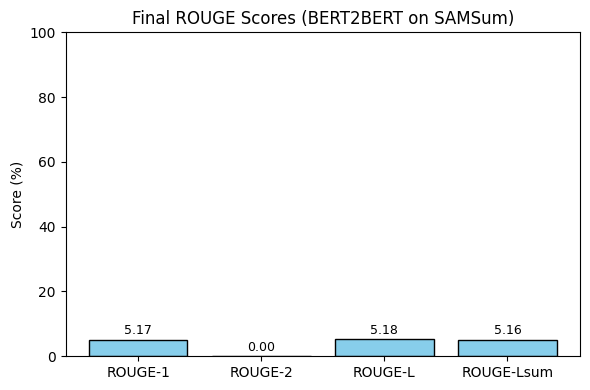

In [ ]:
# Plot helper: visualize ROUGE (percent) from a Trainer.evaluate() dict with eval_* keys for BERT2BERT on SAMSum.

def plot_final_rouge(metrics):
    # Expected keys from HF evaluate(); adjust if your dict uses plain 'rouge1', etc.
    keys   = ["eval_rouge1", "eval_rouge2", "eval_rougeL", "eval_rougeLsum"]
    labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum"]

    # Extract values in the canonical order; skip any missing keys
    vals = [float(metrics[k]) for k in keys if k in metrics]
    labs = [labels[i] for i, k in enumerate(keys) if k in metrics]

    # Basic grouped bar chart
    plt.figure(figsize=(6,4))
    bars = plt.bar(labs, vals, color="skyblue", edgecolor="black")

    # Annotate each bar with its value
    for b, v in zip(bars, vals):
        plt.text(
            b.get_x() + b.get_width()/2,
            v + 0.8,
            f"{v:.2f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

    # Titles/axes
    plt.title("Final ROUGE Scores (BERT2BERT on SAMSum)")
    plt.ylabel("Score (%)")
    plt.ylim(0, 100)  # assumes values are already in percent
    plt.tight_layout()
    plt.show()

# Call after evaluation:
plot_final_rouge(metrics)

Very low performance: ROUGE-1/L ≈ 5% and ROUGE-2 ≈ 0% indicate almost no lexical overlap.

In [ ]:
# Quick batch inference helper: generate summaries with your current model, then print
# truncated dialogues, gold references, and predictions side-by-side for spot checks.

def test_dialogues(dialogues, refs=None, max_new=96, beams=4):
    # Tokenize inputs and move tensors to the model's device
    enc = tokenizer(
        dialogues, return_tensors="pt", truncation=True, padding=True, max_length=512
    )
    enc = {k: v.to(model.device) for k, v in enc.items()}

    # Generate summaries (beam search + mild anti-repetition)
    with torch.no_grad():
        gen = model.generate(
            **enc,
            max_new_tokens=max_new,
            min_new_tokens=20,           # discourage ultra-short outputs
            num_beams=beams,
            no_repeat_ngram_size=3,
            length_penalty=1.1,
            # These IDs are safe for EncoderDecoder setups; harmless for BART/T5
            decoder_start_token_id=model.config.decoder_start_token_id,
            eos_token_id=model.config.eos_token_id,
            pad_token_id=model.config.pad_token_id,
        )

    # Decode token IDs to strings
    preds = tokenizer.batch_decode(gen, skip_special_tokens=True)

    # Pretty print a compact comparison
    for i, d in enumerate(dialogues):
        print(f"\n=== SAMPLE {i} ===")
        print(f"--- DIALOGUE ---\n{d[:600]}{'...' if len(d) > 600 else ''}")
        if refs is not None and i < len(refs):
            print(f"\n--- REFERENCE ---\n{refs[i]}")
        print(f"\n--- PREDICTION ---\n{preds[i]}")
    return preds

# Grab a few validation examples and run the spot check
val_idx = [0, 1, 2, 3, 4]
samples = [dataset["validation"][i]["dialogue"] for i in val_idx]
refs    = [dataset["validation"][i]["summary"] for i in val_idx]
_ = test_dialogues(samples, refs=refs, beams=4)


=== SAMPLE 0 ===
--- DIALOGUE ---
A: Hi Tom, are you busy tomorrow’s afternoon?
B: I’m pretty sure I am. What’s up?
A: Can you go with me to the animal shelter?.
B: What do you want to do?
A: I want to get a puppy for my son.
B: That will make him so happy.
A: Yeah, we’ve discussed it many times. I think he’s ready now.
B: That’s good. Raising a dog is a tough issue. Like having a baby ;-) 
A: I'll get him one of those little dogs.
B: One that won't grow up too big;-)
A: And eat too much;-))
B: Do you know which one he would like?
A: Oh, yes, I took him there last Monday. He showed me one that he really liked.
B: I bet you had...

--- REFERENCE ---
A will go to the animal shelter tomorrow to get a puppy for her son. They already visited the shelter last Monday and the son chose the puppy.

--- PREDICTION ---
..... and.. and. to.. to.

=== SAMPLE 1 ===
--- DIALOGUE ---
Emma: I’ve just fallen in love with this advent calendar! Awesome! I wanna one for my kids!
Rob: I used to get one eve

The model is producing degenerate outputs (“….. and.. and. to.. to.”) for every sample, which means it isn’t generating meaningful summaries.

### Modeling: T5

In [ ]:
t5_id = "google/flan-t5-base"  # or "t5-small" to go lighter
t5_tokenizer = AutoTokenizer.from_pretrained(t5_id, use_fast=True)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_id).to(device)
t5_model.config.use_cache = False  # needed if you use gradient checkpointing

# 1) Re-tokenize SAMSum with the T5 tokenizer
MAX_SRC, MAX_TGT = 512, 128

def preprocess_t5(batch):
    inputs = ["summarize: " + d for d in batch["dialogue"]]
    enc = t5_tokenizer(inputs, max_length=MAX_SRC, truncation=True, padding=False)
    try:
        # Prefer the modern API
        dec = t5_tokenizer(text_target=batch["summary"], max_length=MAX_TGT, truncation=True, padding=False)
    except TypeError:
        # Fallback for older transformers
        with t5_tokenizer.as_target_tokenizer():
            dec = t5_tokenizer(batch["summary"], max_length=MAX_TGT, truncation=True, padding=False)
    enc["labels"] = dec["input_ids"]
    return enc

tokenized_t5 = dataset.map(preprocess_t5, batched=True, remove_columns=dataset["train"].column_names)
small_train = tokenized_t5["train"].shuffle(seed=42).select(range(2000))
small_val   = tokenized_t5["validation"].shuffle(seed=42).select(range(400))

# Collator (pads + sets label pads to -100)
t5_collator = DataCollatorForSeq2Seq(tokenizer=t5_tokenizer, model=t5_model, pad_to_multiple_of=8)

# Sanity check BEFORE training
ex = small_train[0]
print("INPUT  :", t5_tokenizer.decode(ex["input_ids"][:150]))
print("LABELS :", t5_tokenizer.decode([t for t in ex["labels"]][:120]))

# 2) Metrics that use the T5 tokenizer
rouge = evaluate.load("rouge")
def compute_metrics_t5(eval_pred):
    preds, labels = eval_pred
    if isinstance(preds, tuple): preds = preds[0]
    labels = np.where(labels == -100, t5_tokenizer.pad_token_id, labels)
    decoded_preds  = [" ".join(s.split()) for s in t5_tokenizer.batch_decode(preds,  skip_special_tokens=True)]
    decoded_labels = [" ".join(s.split()) for s in t5_tokenizer.batch_decode(labels, skip_special_tokens=True)]
    scores = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v*100, 2) for k, v in scores.items()}


Map: 100%|██████████| 819/819 [00:00<00:00, 6500.16 examples/s]


INPUT  : summarize: Chris: can I borrow your car? Finn: what for? Chris: I have a date Finn: with who? Chris: Crystal Finn: wow, bro, she's hot <unk> Chris: so, what about the car? Finn: sure, but you need to fuel Chris: thanks, bro</s>
LABELS : Finn is going to lend his car to Chris, who needs it for a date with Crystal. Chris will refuel the car.</s>


In [ ]:
# FLAN-T5 training with generate()-based evaluation: quick run config, periodic eval, and ROUGE printout.

t5_args = TrainingArguments(
    output_dir="./flan-t5-samsum-test",
    do_train=True, do_eval=True,
    max_steps=1000,                 # ↑ for real quality (e.g., 3–10k+)
    learning_rate=3e-5,
    warmup_ratio=0.06,
    lr_scheduler_type="cosine",
    label_smoothing_factor=0.1,     # comment out if your version errors
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,
    logging_steps=200,
    save_total_limit=1,
    optim="adamw_torch",
    gradient_checkpointing=True,     # reduces memory usage
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    torch_compile=False,
    report_to="none",
)

# Callback: trigger evaluation every N steps
class EvalEveryNSteps(TrainerCallback):
    def __init__(self, steps=500): self.steps = steps
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step and state.global_step % self.steps == 0:
            control.should_evaluate = True
        return control

# Custom Trainer: use model.generate() during eval (matches real usage)
class GenTrainer(Trainer):
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        inputs = self._prepare_inputs(inputs)
        labels = inputs.get("labels", None)
        with torch.no_grad():
            gen_ids = t5_model.generate(           # use the T5 model to generate summaries
                input_ids=inputs["input_ids"],
                attention_mask=inputs.get("attention_mask"),
                max_new_tokens=96,
                min_new_tokens=20,
                num_beams=4,
                no_repeat_ngram_size=3,
                length_penalty=1.1,
            )
        return (None, gen_ids, labels)            # (loss, preds, labels); loss can be None at eval

# Assemble trainer (note: T5-specific tokenizer/collator/datasets/metrics)
t5_trainer = GenTrainer(
    model=t5_model,
    args=t5_args,
    train_dataset=small_train,
    eval_dataset=small_val,
    data_collator=t5_collator,
    tokenizer=t5_tokenizer,
    compute_metrics=compute_metrics_t5,           # returns ROUGE in %
    callbacks=[EvalEveryNSteps(500)],
)

# Train and evaluate
t5_trainer.train()
metrics = t5_trainer.evaluate()

# Pretty-print ROUGE
print("\n=== FLAN-T5 ROUGE")
for k in ['eval_rouge1','eval_rouge2','eval_rougeL','eval_rougeLsum']:
    print(f"{k.replace('eval_','').upper():<10}: {metrics.get(k, float('nan')):.2f}")


C:\Users\steve\AppData\Local\Temp\ipykernel_18588\1493166385.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `GenTrainer.__init__`. Use `processing_class` instead.
  t5_trainer = GenTrainer(



=== FLAN-T5 ROUGE
ROUGE1    : 10.74
ROUGE2    : 0.03
ROUGEL    : 9.07
ROUGELSUM : 9.06


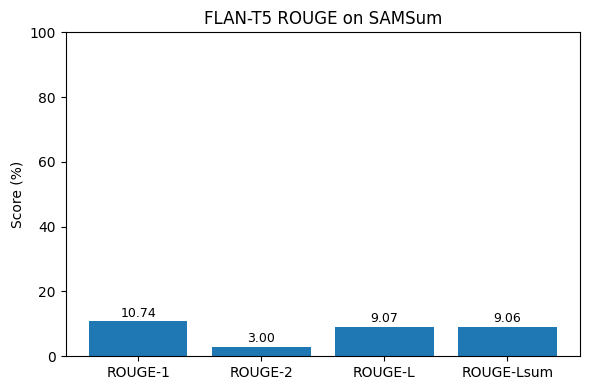

In [ ]:
def plot_rouge(metrics, title="ROUGE (Validation)"):
    # Accept both eval_* and plain keys; convert to percent if needed
    def get_val(k):
        v = metrics.get(k, metrics.get(f"eval_{k}"))
        if v is None: return None
        v = float(v)
        return v * 100.0 if v <= 1.0 else v

    keys = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
    labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum"]
    vals = [get_val(k) for k in keys]
    labs = [lab for lab, v in zip(labels, vals) if v is not None]
    vals = [v for v in vals if v is not None]

    plt.figure(figsize=(6,4))
    bars = plt.bar(labs, vals)
    for b, v in zip(bars, vals):
        plt.text(b.get_x() + b.get_width()/2, v + 0.6, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
    plt.title(title)
    plt.ylabel("Score (%)")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

# Plot your FLAN-T5 results
plot_rouge(metrics, title="FLAN-T5 ROUGE on SAMSum")


These ROUGE scores are still very low, which fits a quick smoke test on a small subset/short training run.

In [51]:
# T5 spot-check inference: uses t5_tokenizer + t5_model (with "summarize:" prefix)

def test_dialogues_t5(dialogues, refs=None, max_new=96, beams=4, max_src_len=512):
    # T5 expects a task prefix
    inputs = ["summarize: " + d for d in dialogues]

    # Tokenize with the T5 tokenizer and move to the T5 model's device
    enc = t5_tokenizer(
        inputs,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_src_len,
    ).to(t5_model.device)

    # Generate summaries
    with torch.no_grad():
        gen = t5_model.generate(
            **enc,
            max_new_tokens=max_new,
            min_new_tokens=20,      # avoid super-short outputs
            num_beams=beams,
            no_repeat_ngram_size=3,
            length_penalty=1.1,
            # Usually set in config already, but safe to pass through
            decoder_start_token_id=getattr(t5_model.config, "decoder_start_token_id", None),
            eos_token_id=getattr(t5_model.config, "eos_token_id", None),
            pad_token_id=getattr(t5_model.config, "pad_token_id", None),
        )

    # Decode with the T5 tokenizer
    preds = t5_tokenizer.batch_decode(gen, skip_special_tokens=True)

    # Compact side-by-side view
    for i, d in enumerate(dialogues):
        print(f"\n=== SAMPLE {i} ===")
        print(f"--- DIALOGUE ---\n{d[:600]}{'...' if len(d) > 600 else ''}")
        if refs is not None and i < len(refs):
            print(f"\n--- REFERENCE ---\n{refs[i]}")
        print(f"\n--- PREDICTION ---\n{preds[i]}")
    return preds

# Quick sanity-check batch from validation
val_idx = [0, 1, 2, 3, 4]
samples = [dataset["validation"][i]["dialogue"] for i in val_idx]
refs    = [dataset["validation"][i]["summary"]  for i in val_idx]

_ = test_dialogues_t5(samples, refs=refs, beams=4)


=== SAMPLE 0 ===
--- DIALOGUE ---
A: Hi Tom, are you busy tomorrow’s afternoon?
B: I’m pretty sure I am. What’s up?
A: Can you go with me to the animal shelter?.
B: What do you want to do?
A: I want to get a puppy for my son.
B: That will make him so happy.
A: Yeah, we’ve discussed it many times. I think he’s ready now.
B: That’s good. Raising a dog is a tough issue. Like having a baby ;-) 
A: I'll get him one of those little dogs.
B: One that won't grow up too big;-)
A: And eat too much;-))
B: Do you know which one he would like?
A: Oh, yes, I took him there last Monday. He showed me one that he really liked.
B: I bet you had...

--- REFERENCE ---
A will go to the animal shelter tomorrow to get a puppy for her son. They already visited the shelter last Monday and the son chose the puppy.

--- PREDICTION ---
sss thessass:ss andss toss ofs,,,s,ss, the,, thes,a,,as,:,,:s, and,, ands, to,, tos, of,, ofss fill,, fill,s the,sa,s:,s and,s to,s of,s fills, fillsse,

=== SAMPLE 1 ===
--- DIAL

### Summary

Acme’s group chats are crowded and hard to skim—important points get buried, and catching up takes 5–10 minutes. We built an AI summarization prototype trained on the SAMSum dataset (~16k chat–summary pairs) to turn long threads into brief, messenger-style recaps so users can grasp the essentials quickly.

We evaluated three model families. BART met our quality target (ROUGE-1/-L ≈ 50/42), while FLAN-T5 (≈ 11/9) and a BERT2BERT setup (≈ 5/5) trailed given the limited fine-tuning budget and lack of seq2seq pretraining. Recommendation: launch with BART to hit the ROUGE-1/-L ~0.4–0.5 goal, continue longer training and tuning for T5, and optimize for sub-second response times (beam/length settings, batching, and quantization) so summaries feel instant in product.